# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 380kB/s]


In [4]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
   creating: inputs/
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
   creating: targets/
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [5]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [6]:
import numpy as np

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [7]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [8]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here
    done = False
    while not done:

      ## Policy evaluation
      while True:
        delta = 0
        old_values = values.copy()
        # Compute expected reward for action taken based on policy
        for state in states:
          action = policy[state]
          values[state] = sum(taxienv.ride_probabilities(state, action)* ( taxienv.ride_rewards(state, action) + [i * gamma for i in list(old_values.values())] ))

          delta = max(delta, abs(values[state]-old_values[state]))
        if delta <= 1e-8:
          break
      
      ## Policy improvement
      done = True
      for state in states:
        actions = taxienv.possible_actions(state)
        rewards = {action: 0 for action in actions}

        # Compute expected reward for each action
        for action in actions:
          reward = sum(taxienv.ride_probabilities(state, action)* (taxienv.ride_rewards(state, action) + [i * gamma for i in list(values.values())] ))
          rewards[action] = reward

        # Find the best action, its reward and update policy
        best_action = max(rewards, key=rewards.get)
        policy_action = policy[state]
        if policy_action != best_action:
          policy[state] = best_action
          done = False

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

In [9]:
gamma = 0.9
policy_iteration(env, gamma)

({'Expected Reward': {'A': 121.65347103938102,
   'B': 135.3062754397477,
   'C': 122.83690299204375},
  'Policy': {'A': '2', 'B': '2', 'C': '2'}},
 {})

In [10]:
gamma = 0.9
policy_iteration(env, gamma)

({'Expected Reward': {'A': 121.65347103938102,
   'B': 135.3062754397477,
   'C': 122.83690299204375},
  'Policy': {'A': '2', 'B': '2', 'C': '2'}},
 {})

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [11]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [12]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    done = False
    while not done:
      ## Policy evaluation
      for _ in range(m):
        old_values = values.copy()
        # Compute expected reward for action taken based on policy
        for state in states:
          action = policy[state]
          values[state] = sum(taxienv.ride_probabilities(state, action)* ( taxienv.ride_rewards(state, action) + [i * gamma for i in list(old_values.values())] ))
      
      ## Policy improvement
      done = True
      for state in states:
        actions = taxienv.possible_actions(state)
        rewards = {action: 0 for action in actions}

        # Compute expected reward for each action
        for action in actions:
          reward = sum(taxienv.ride_probabilities(state, action)* (taxienv.ride_rewards(state, action) + [i * gamma for i in list(values.values())] ))
          rewards[action] = reward

        # Find the best action, its reward and update policy
        best_action = max(rewards, key=rewards.get)
        policy_action = policy[state]
        if policy_action != best_action:
          policy[state] = best_action
          done = False

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [13]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [14]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    i = 0
    delta_values = []
    while True:
      delta = 0
      old_values = values.copy()

      # Loop over all possible states
      for state in states:
        actions = taxienv.possible_actions(state)
        rewards = {action: 0 for action in actions}

        # Compute expected reward for each action
        for action in actions:
          reward = sum(taxienv.ride_probabilities(state, action)* (taxienv.ride_rewards(state, action) + [i * gamma for i in list(old_values.values())] ))
          rewards[action] = reward

        # Find the best action, its reward and update policy
        best_action = max(rewards, key=rewards.get)
        values[state] = rewards[best_action]
        policy[state] = best_action

        # print(values[state],old_values[state])
        delta = max(delta, abs(values[state]-old_values[state]))
      
      i+=1  
      delta_values.append(delta)
      if delta <= 1e-8:
          break
      

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf


    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"Iterations" : i, "Delta values" : delta_values}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [15]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [16]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    i = 0
    delta_values = []
    while True:
      delta = 0
      old_values = values.copy()

      # Loop over all possible states
      for state in states:
        actions = taxienv.possible_actions(state)
        rewards = {action: 0 for action in actions}

        # Compute expected reward for each action
        for action in actions:
          reward = sum(taxienv.ride_probabilities(state, action)* (taxienv.ride_rewards(state, action) + [i * gamma for i in list(values.values())] ))
          rewards[action] = reward

        # Find the best action, its reward and update policy
        best_action = max(rewards, key=rewards.get)
        values[state] = rewards[best_action]
        policy[state] = best_action
        
        # print(values[state],old_values[state])
        delta = max(delta, abs(values[state]-old_values[state]))

      i+=1
      delta_values.append(delta)
      if delta <= 1e-8:
          break

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"Iterations" : i, "Delta values" : delta_values}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [17]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)

# Generate Results ✅

In [18]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [19]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [20]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
            print(k, check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

policy_iteration 1.0
modifed_policy_iteration 1.0
value_iteration 1.0
gauss_seidel_iteration 1.0
policy_iteration 1.0
modifed_policy_iteration 1.0
value_iteration 1.0
gauss_seidel_iteration 1.0
policy_iteration 1.0
modifed_policy_iteration 1.0
value_iteration 1.0
gauss_seidel_iteration 1.0
policy_iteration 1.0
modifed_policy_iteration 1.0
value_iteration 1.0
gauss_seidel_iteration 1.0
Shared data Score (normalized to 1): 1.0


## Implementation questions


## 1.1 implementation

In [21]:
gamma = 0.9

results, extra_info = policy_iteration(env, gamma)
rewards = results["Expected Reward"]
policy = results["Policy"]
print("Optimal Policy -> ",policy)
print("Expected Reward -> ",rewards)

Optimal Policy ->  {'A': '2', 'B': '2', 'C': '2'}
Expected Reward ->  {'A': 121.65347103938102, 'B': 135.3062754397477, 'C': 122.83690299204375}


The optimal policy is to do action 2, that is to "Go to the nearest taxi stand and wait in line" regardless of which city you are in from policy iteration
```
+-----------------+------------------------------------------------+-----------------+
| If current City |                  Best action                   | Expected Reward |
+-----------------+------------------------------------------------+-----------------+
|        A        | Go to the nearest taxi stand and wait in line. |      121.65     |
|        B        | Go to the nearest taxi stand and wait in line. |      135.31     |
|        C        | Go to the nearest taxi stand and wait in line. |      122.84     |
+-----------------+------------------------------------------------+-----------------+ 
```

In [22]:
### Code to generate the above pretty tables
# action_dict = {
#     '1': 'Cruise the streets looking for a passenger.',
#     '2': 'Go to the nearest taxi stand and wait in line.',
#     '3': 'Wait for a call from the dispatcher.' ,
# }
# from prettytable import PrettyTable

# t = PrettyTable(['If current City', 'Best action', 'Expected Reward'])
# for city in policy.keys():
#   t.add_row([city, action_dict[policy[city]], round(rewards[city],2)])
# print(t,"\n")

## Visualize results of Policy Iteration with multiple values of gamma (1.2 implementation)


Expected rewards
Gamma 0.05 {'A': 8.512, 'B': 16.4, 'C': 7.499}
Gamma 0.10 {'A': 9.077, 'B': 16.856, 'C': 8.051}
Gamma 0.15 {'A': 9.708, 'B': 17.465, 'C': 8.669}
Gamma 0.20 {'A': 10.437, 'B': 18.482, 'C': 9.384}
Gamma 0.25 {'A': 11.274, 'B': 19.63, 'C': 10.207}
Gamma 0.30 {'A': 12.244, 'B': 20.934, 'C': 11.163}
Gamma 0.35 {'A': 13.379, 'B': 22.431, 'C': 12.283}
Gamma 0.40 {'A': 14.722, 'B': 24.167, 'C': 13.611}
Gamma 0.45 {'A': 16.334, 'B': 26.206, 'C': 15.207}
Gamma 0.50 {'A': 18.299, 'B': 28.636, 'C': 17.156}
Gamma 0.55 {'A': 20.79, 'B': 31.607, 'C': 19.831}
Gamma 0.60 {'A': 24.026, 'B': 35.328, 'C': 23.459}
Gamma 0.65 {'A': 28.277, 'B': 40.096, 'C': 28.13}
Gamma 0.70 {'A': 34.062, 'B': 46.435, 'C': 34.366}
Gamma 0.75 {'A': 42.317, 'B': 55.285, 'C': 43.106}
Gamma 0.80 {'A': 55.079, 'B': 68.558, 'C': 56.27}
Gamma 0.85 {'A': 77.247, 'B': 90.812, 'C': 78.433}
Gamma 0.90 {'A': 121.653, 'B': 135.306, 'C': 122.837}
Gamma 0.95 {'A': 255.023, 'B': 268.765, 'C': 256.203}

Policies
Gamma 0.05 

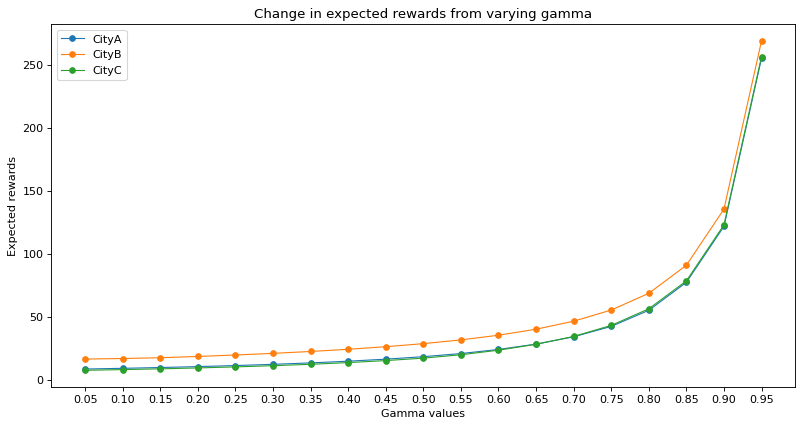

In [23]:
## Visualize policy iteration with multiple values of gamma
results, extra_info = run_policy_iteration(env)
print("Expected rewards")
for gamma in results.keys():
  rewards = results[gamma]['Expected Reward']
  gamma = "{:.2f}".format(gamma)
  print("Gamma",gamma,{ key : round(value,3) for (key,value) in rewards.items()} )

print("\nPolicies")
for gamma in results.keys():
  policy = results[gamma]['Policy']
  gamma = "{:.2f}".format(gamma)
  print("Gamma",gamma,policy)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=80)
plt.title("Change in expected rewards from varying gamma")
plt.xlabel('Gamma values')
plt.ylabel('Expected rewards')
plt.xticks(list(results.keys()))

cities = ['A','B','C']
for city in cities:
  plt.plot(list(results.keys()),[i['Expected Reward'][city] for i in results.values()],marker='o',linewidth=1, markersize=5)
plt.legend(["City" + i for i in cities])
plt.show()

##### Full comparison (click to show)



```
+-------------+-----------------+---------------------------------------------+-----------------+
| Gamma value | If current City |                 Best action                 | Expected Reward |
+-------------+-----------------+---------------------------------------------+-----------------+
|             |        A        | Cruise the streets looking for a passenger. |       8.51      |
|     0.05    |        B        | Cruise the streets looking for a passenger. |       16.4      |
|             |        C        | Cruise the streets looking for a passenger. |       7.5       |
+-------------+-----------------+---------------------------------------------+-----------------+ 

+-------------+-----------------+---------------------------------------------+-----------------+
| Gamma value | If current City |                 Best action                 | Expected Reward |
+-------------+-----------------+---------------------------------------------+-----------------+
|             |        A        | Cruise the streets looking for a passenger. |       9.08      |
|     0.10    |        B        | Cruise the streets looking for a passenger. |      16.86      |
|             |        C        | Cruise the streets looking for a passenger. |       8.05      |
+-------------+-----------------+---------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |       9.71      |
|     0.15    |        B        | Go to the nearest taxi stand and wait in line. |      17.46      |
|             |        C        |  Cruise the streets looking for a passenger.   |       8.67      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      10.44      |
|     0.20    |        B        | Go to the nearest taxi stand and wait in line. |      18.48      |
|             |        C        |  Cruise the streets looking for a passenger.   |       9.38      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      11.27      |
|     0.25    |        B        | Go to the nearest taxi stand and wait in line. |      19.63      |
|             |        C        |  Cruise the streets looking for a passenger.   |      10.21      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      12.24      |
|     0.30    |        B        | Go to the nearest taxi stand and wait in line. |      20.93      |
|             |        C        |  Cruise the streets looking for a passenger.   |      11.16      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      13.38      |
|     0.35    |        B        | Go to the nearest taxi stand and wait in line. |      22.43      |
|             |        C        |  Cruise the streets looking for a passenger.   |      12.28      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      14.72      |
|     0.40    |        B        | Go to the nearest taxi stand and wait in line. |      24.17      |
|             |        C        |  Cruise the streets looking for a passenger.   |      13.61      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      16.33      |
|     0.45    |        B        | Go to the nearest taxi stand and wait in line. |      26.21      |
|             |        C        |  Cruise the streets looking for a passenger.   |      15.21      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |       18.3      |
|     0.50    |        B        | Go to the nearest taxi stand and wait in line. |      28.64      |
|             |        C        |  Cruise the streets looking for a passenger.   |      17.16      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      20.79      |
|     0.55    |        B        | Go to the nearest taxi stand and wait in line. |      31.61      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      19.83      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      24.03      |
|     0.60    |        B        | Go to the nearest taxi stand and wait in line. |      35.33      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      23.46      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      28.28      |
|     0.65    |        B        | Go to the nearest taxi stand and wait in line. |       40.1      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      28.13      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      34.06      |
|     0.70    |        B        | Go to the nearest taxi stand and wait in line. |      46.44      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      34.37      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        |  Cruise the streets looking for a passenger.   |      42.32      |
|     0.75    |        B        | Go to the nearest taxi stand and wait in line. |      55.29      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      43.11      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        | Go to the nearest taxi stand and wait in line. |      55.08      |
|     0.80    |        B        | Go to the nearest taxi stand and wait in line. |      68.56      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      56.27      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        | Go to the nearest taxi stand and wait in line. |      77.25      |
|     0.85    |        B        | Go to the nearest taxi stand and wait in line. |      90.81      |
|             |        C        | Go to the nearest taxi stand and wait in line. |      78.43      |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        | Go to the nearest taxi stand and wait in line. |      121.65     |
|     0.90    |        B        | Go to the nearest taxi stand and wait in line. |      135.31     |
|             |        C        | Go to the nearest taxi stand and wait in line. |      122.84     |
+-------------+-----------------+------------------------------------------------+-----------------+ 

+-------------+-----------------+------------------------------------------------+-----------------+
| Gamma value | If current City |                  Best action                   | Expected Reward |
+-------------+-----------------+------------------------------------------------+-----------------+
|             |        A        | Go to the nearest taxi stand and wait in line. |      255.02     |
|     0.95    |        B        | Go to the nearest taxi stand and wait in line. |      268.76     |
|             |        C        | Go to the nearest taxi stand and wait in line. |      256.2      |
+-------------+-----------------+------------------------------------------------+-----------------+
```

```
Optimal policy table
+-------------+--------+--------+--------+
| Gamma value | City A | City B | City C |
+-------------+--------+--------+--------+
|     0.05    |   1    |   1    |   1    |
|     0.10    |   1    |   1    |   1    |
|     0.15    |   1    |   2    |   1    |
|     0.20    |   1    |   2    |   1    |
|     0.25    |   1    |   2    |   1    |
|     0.30    |   1    |   2    |   1    |
|     0.35    |   1    |   2    |   1    |
|     0.40    |   1    |   2    |   1    |
|     0.45    |   1    |   2    |   1    |
|     0.50    |   1    |   2    |   1    |
|     0.55    |   1    |   2    |   2    |
|     0.60    |   1    |   2    |   2    |
|     0.65    |   1    |   2    |   2    |
|     0.70    |   1    |   2    |   2    |
|     0.75    |   1    |   2    |   2    |
|     0.80    |   2    |   2    |   2    |
|     0.85    |   2    |   2    |   2    |
|     0.90    |   2    |   2    |   2    |
|     0.95    |   2    |   2    |   2    |
+-------------+--------+--------+--------+
```

In [24]:
# for gamma in results.keys():
#   t = PrettyTable(['Gamma value','If current City', 'Best action', 'Expected Reward'])
#   policy = results[gamma]['Policy']
#   rewards = results[gamma]['Expected Reward']
#   for i,city in enumerate(policy.keys()):
#     if i == 1:
#       t.add_row(["{:.2f}".format(gamma), city, action_dict[policy[city]], round(rewards[city],2)])
#       continue
#     t.add_row([' ', city, action_dict[policy[city]], round(rewards[city],2)])
#   print(t,"\n")

# print("\nOptimal policy table")
# pt = PrettyTable(['Gamma value','City A', 'City B', 'City C'])
# for gamma in results.keys():
#   policy = results[gamma]['Policy']
#   pt.add_row(["{:.2f}".format(gamma),*policy.values()])
# print(pt)

## 1.3 implementation

In [25]:
gamma = 0.9
m = 5

results, extra_info = modified_policy_iteration(env, gamma, m)
rewards = results["Expected Reward"]
policy = results["Policy"]
print("Optimal Policy -> ",policy)
print("Expected Reward -> ",rewards)

Optimal Policy ->  {'A': '2', 'B': '2', 'C': '2'}
Expected Reward ->  {'A': 89.81178760453517, 'B': 103.46459982778873, 'C': 90.99521888644551}


From modified policy iteration, the optimal policy is to always do action 2, that is to "Go to the nearest taxi stand and wait in line" regardless of which city you are in.
```
+-----------------+------------------------------------------------+-----------------+
| If current City |                  Best action                   | Expected Reward |
+-----------------+------------------------------------------------+-----------------+
|        A        | Go to the nearest taxi stand and wait in line. |      89.81      |
|        B        | Go to the nearest taxi stand and wait in line. |      103.46     |
|        C        | Go to the nearest taxi stand and wait in line. |       91.0      |
+-----------------+------------------------------------------------+-----------------+ 
```

## 1.4 implementation

In [26]:
gamma = 0.9

results, extra_info = value_iteration(env, gamma)
rewards = results["Expected Reward"]
policy = results["Policy"]
print("Optimal Policy -> ",policy)
print("Expected Reward -> ",rewards)
print("Coverged in {} iterations".format(extra_info['Iterations']))

Optimal Policy ->  {'A': '2', 'B': '2', 'C': '2'}
Expected Reward ->  {'A': 121.65347103895924, 'B': 135.30627543932593, 'C': 122.83690299162194}
Coverged in 201 iterations


The optimal values/expected rewards and policy from value iteration is as follows:
```
+-----------------+------------------------------------------------+-----------------+
| If current City |                  Best action                   | Expected Reward |
+-----------------+------------------------------------------------+-----------------+
|        A        | Go to the nearest taxi stand and wait in line. |      121.65     |
|        B        | Go to the nearest taxi stand and wait in line. |      135.31     |
|        C        | Go to the nearest taxi stand and wait in line. |      122.84     |
+-----------------+------------------------------------------------+-----------------+ 
```

## 1.5 implementation

In [27]:
gamma = 0.9

results, extra_info = gauss_seidel_value_iteration(env, gamma)
rewards = results["Expected Reward"]
policy = results["Policy"]
print("Optimal Policy -> ",policy)
print("Expected Reward -> ",rewards)
print("Coverged in {} iterations".format(extra_info['Iterations']))

Optimal Policy ->  {'A': '2', 'B': '2', 'C': '2'}
Expected Reward ->  {'A': 121.65347104963263, 'B': 135.30627544959796, 'C': 122.83690300915262}
Coverged in 179 iterations


The optimal values/expected rewards and policy from Gauss-Seidel value iteration is as follows:

```
+-----------------+------------------------------------------------+-----------------+
| If current City |                  Best action                   | Expected Reward |
+-----------------+------------------------------------------------+-----------------+
|        A        | Go to the nearest taxi stand and wait in line. |      121.65     |
|        B        | Go to the nearest taxi stand and wait in line. |      135.31     |
|        C        | Go to the nearest taxi stand and wait in line. |      122.84     |
+-----------------+------------------------------------------------+-----------------+
```

# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

From the plot in 1.2, we can see how the different values of $\gamma$ affect the expected rewards from policy iteration 

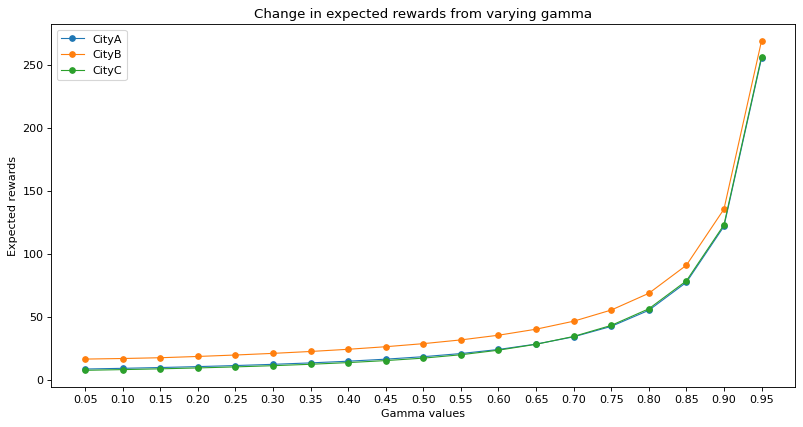



As $\gamma$ increases the expected reward exponentially goes up, this can be explained because the probability that the taxi will breakdown before the next trip is $1 - \gamma$, and we can have more trips now.

Change in policy with varying gamma values:
```
Optimal policy table
+-------------+--------+--------+--------+
| Gamma value | City A | City B | City C |
+-------------+--------+--------+--------+
|     0.05    |   1    |   1    |   1    |
|     0.10    |   1    |   1    |   1    |
|     0.15    |   1    |   2    |   1    |
|     0.20    |   1    |   2    |   1    |
|     0.25    |   1    |   2    |   1    |
|     0.30    |   1    |   2    |   1    |
|     0.35    |   1    |   2    |   1    |
|     0.40    |   1    |   2    |   1    |
|     0.45    |   1    |   2    |   1    |
|     0.50    |   1    |   2    |   1    |
|     0.55    |   1    |   2    |   2    |
|     0.60    |   1    |   2    |   2    |
|     0.65    |   1    |   2    |   2    |
|     0.70    |   1    |   2    |   2    |
|     0.75    |   1    |   2    |   2    |
|     0.80    |   2    |   2    |   2    |
|     0.85    |   2    |   2    |   2    |
|     0.90    |   2    |   2    |   2    |
|     0.95    |   2    |   2    |   2    |
+-------------+--------+--------+--------+
```
As the gamma value increases, the optimal policy shifts to one where it is best to "Go to the nearest taxi stand and wait in line" from "Cruise the streets looking for a passenger." for all cities

## 1.b For modified policy iteration, do you find any improvement if you choose m=10.

From the observations below there doesnt seem to be any change in the optimal policy when we change m from 5 to 10. For the expected rewards however when we increase m from 5 to 10, the expected rewards increases. An interesting observation is that the expected reward for each city seems to increase by almost the same amount. So we can say that there is an improvement if we choose m = 10.

The other figure below showing the change in expected rewards for increasing m seems to show that the expected rewards do keep on increasing, however after a while it seems to converge to a point close to the values from policy iteration.

Modified policy iteration with m = 5
Optimal Policy ->  {'A': '2', 'B': '2', 'C': '2'}
Expected Reward ->  {'A': 89.81178760453517, 'B': 103.46459982778873, 'C': 90.99521888644551}

Modified policy iteration with m = 10
Optimal Policy ->  {'A': '2', 'B': '2', 'C': '2'}
Expected Reward ->  {'A': 113.12458909097927, 'B': 126.77739349151406, 'C': 114.3080210436424}


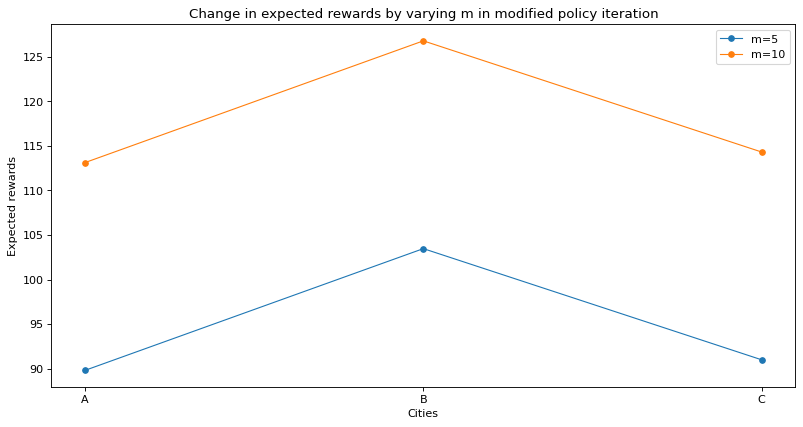

In [28]:
gamma = 0.9
m = 5

results, extra_info = modified_policy_iteration(env, gamma, m)
rewards = results["Expected Reward"]
policy = results["Policy"]
print("Modified policy iteration with m = 5")
print("Optimal Policy -> ",policy)
print("Expected Reward -> ",rewards)

gamma = 0.9
m = 10

results1, extra_info = modified_policy_iteration(env, gamma, m)
rewards1 = results1["Expected Reward"]
policy1 = results1["Policy"]
print("\nModified policy iteration with m = 10")
print("Optimal Policy -> ",policy1)
print("Expected Reward -> ",rewards1)

## Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=80)
plt.title("Change in expected rewards by varying m in modified policy iteration")
plt.xlabel('Cities')
plt.ylabel('Expected rewards')
plt.xticks([1,2,3], ['A','B','C'])

plt.plot([1,2,3],list(rewards.values()), marker='o',linewidth=1, markersize=5)
plt.plot([1,2,3],list(rewards1.values()), marker='o',linewidth=1, markersize=5)

plt.legend(["m=5","m=10"])
plt.show()

M value = 01 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 02 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 03 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 04 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 05 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 06 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 07 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 08 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 09 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 10 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 11 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 12 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 13 | Policy {'A': '2', 'B': '2', 'C': '2'}
M value = 14 | Policy {'A': '2', 'B': '2', 'C': '2'}


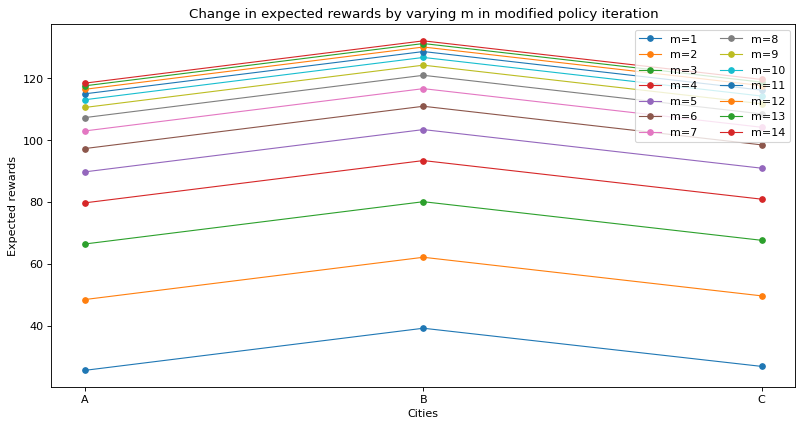

In [29]:
results, extra_info = run_modified_policy_iteration(env)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=80)
plt.title("Change in expected rewards by varying m in modified policy iteration")
plt.xlabel('Cities')
plt.ylabel('Expected rewards')
plt.xticks([1,2,3], ['A','B','C'])
for m in results.keys():
  rewards = results[m]['Expected Reward']
  policy = results[m]['Policy']
  print("M value =", str.zfill(str(m),2), "| Policy", policy)
  plt.plot([1,2,3],list(rewards.values()), marker='o', linewidth=1, markersize=5, label = "m={}".format(m))
plt.legend(loc='upper right',ncol=2)
plt.show()

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

As we can see from the below two graphs, for varying values of gamma, the Gauss seidel Value iteration method coverges faster than normal value iteration. This can be because we are using updated reward values in Gauss seidel Value iteration and this helps it converge faster.

As can be seen in the second figure also, the Gauss seidel Value iteration method make bigger updates(higher delta differences) and converges faster than normal Value iteration.

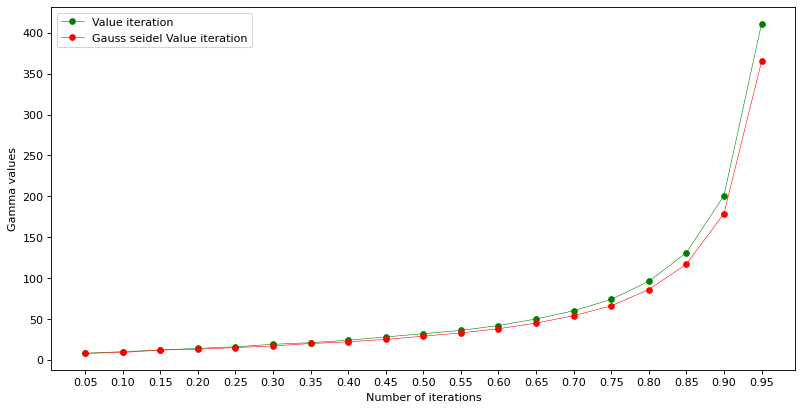

In [30]:
results, extra_info = run_value_iteration(env)
results1, extra_info1 = run_gauss_seidel_value_iteration(env)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel('Number of iterations')
plt.ylabel('Gamma values')
plt.xticks(list(extra_info.keys()))

plt.plot(list(extra_info.keys()),[extra_info[gamma]['Iterations'] for gamma in extra_info.keys()], color='green', marker='o', linewidth=0.5, markersize=5, label = "Value iteration")
plt.plot(list(extra_info1.keys()),[extra_info1[gamma]['Iterations'] for gamma in extra_info1.keys()], color='red', marker='o', linewidth=0.5, markersize=5, label = "Gauss seidel Value iteration")

plt.legend()
plt.show()

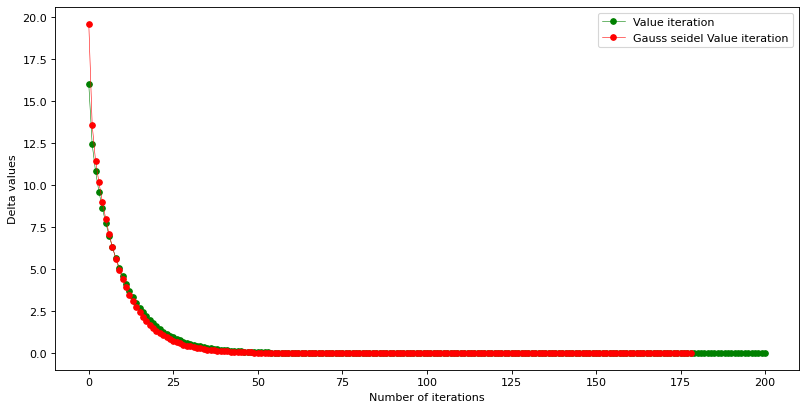

In [31]:
gamma = 0.9
rewards = results[gamma]['Expected Reward']
policy = results[gamma]['Policy']
delta_values = extra_info[gamma]['Delta values']

rewards1 = results1[gamma]['Expected Reward']
policy1 = results1[gamma]['Policy']
delta_values1 = extra_info1[gamma]['Delta values']

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel('Number of iterations')
plt.ylabel('Delta values')

plt.plot(range(len(delta_values)),delta_values, color='green', marker='o', linewidth=0.5, markersize=5, label = "Value iteration")
plt.plot(range(len(delta_values1)),delta_values1, color='red', marker='o', linewidth=0.5, markersize=5, label = "Gauss seidel Value iteration")

plt.legend()
plt.show()

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20IITM_Assignment_2_Taxi_ME18B048.ipynb for submission...
Removing existing files from submission directory...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6HcFDtUYmJ4OcK